In [1]:

import torch
import numpy as np
import pandas as pd
import torch.nn as nn

from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.datasets import STL10
import itertools
import torch.optim as optim
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

In [2]:
transform = transforms.Compose([
	transforms.ToTensor(),
])


In [3]:
trainData = STL10('./data', split='train', transform=transform, download=True)
testData = STL10('./data', split='test', transform=transform, download=True)

100%|██████████| 2640397119/2640397119 [00:27<00:00, 96572383.23it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(trainData[110][0])

tensor([[[0.3608, 0.4078, 0.3412,  ..., 0.2627, 0.2314, 0.2314],
         [0.3804, 0.2275, 0.1765,  ..., 0.2353, 0.2196, 0.2275],
         [0.2745, 0.2039, 0.1098,  ..., 0.2275, 0.2588, 0.2549],
         ...,
         [0.7529, 0.7725, 0.6627,  ..., 0.2902, 0.3608, 0.5647],
         [0.5608, 0.5961, 0.6941,  ..., 0.3451, 0.2667, 0.4510],
         [0.7020, 0.7176, 0.7020,  ..., 0.2392, 0.3294, 0.2431]],

        [[0.5059, 0.5765, 0.5412,  ..., 0.6235, 0.5843, 0.5451],
         [0.5294, 0.3490, 0.3529,  ..., 0.4902, 0.4235, 0.3725],
         [0.5490, 0.3804, 0.2196,  ..., 0.4235, 0.4392, 0.4039],
         ...,
         [0.7686, 0.7922, 0.6980,  ..., 0.5255, 0.6157, 0.7843],
         [0.6000, 0.6157, 0.7098,  ..., 0.5922, 0.5333, 0.6980],
         [0.7412, 0.7451, 0.7137,  ..., 0.5412, 0.6000, 0.5176]],

        [[0.3843, 0.4118, 0.2902,  ..., 0.0667, 0.0549, 0.0784],
         [0.3843, 0.1922, 0.1686,  ..., 0.0824, 0.0863, 0.1137],
         [0.1961, 0.1333, 0.1529,  ..., 0.1020, 0.1098, 0.

In [5]:
print("Train Dataset Size: ", len(trainData))
print("Shape: ", trainData.data.shape)
print("Test Dataset Size: ", len(testData))
print("Shape: ", testData.data.shape)

Train Dataset Size:  5000
Shape:  (5000, 3, 96, 96)
Test Dataset Size:  8000
Shape:  (8000, 3, 96, 96)


dos bacth uno de 5000 para entrenamiento y otro de 8000 para prueba,3 canalaes, 96 alto y 96 ancho

Dataset contiene 13000 imagenes clasificadas en 10 catergorias o etiquetas.

In [6]:
classes = trainData.classes
print("Number of classes = ", len(classes))
print(classes)

Number of classes =  10
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [7]:

image, label = trainData[0]
image.shape

torch.Size([3, 96, 96])

Label (numeric): 0
Label (textual): airplane


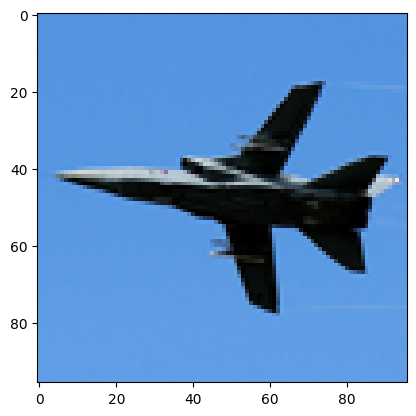

In [8]:
image, label = trainData[200]
plt.imshow(image.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
# import numpy as np
# import scipy.signal
# from skimage import color
# from skimage import exposure
# import random

# ix = random.randint(0, len(trainData))
# img, label = trainData[ix]
# plt.imshow(image.permute((1, 2, 0)))
# img = color.rgb2gray(img)

# kernel = np.array([[1,1,1],
#                    [0,0,0],
#                    [-1,-1,-1]])

# edges = scipy.signal.convolve2d(img, kernel, 'valid')
# edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# ax1.imshow(img, cmap=plt.cm.gray)
# ax2.imshow(edges, cmap=plt.cm.gray)
# plt.show()

In [10]:
classCount = {}
for i,j in trainData:
    labels = classes[j]
    if labels not in classCount:
        classCount[labels] = 0
    classCount[labels] += 1
classCount

{'bird': 500,
 'dog': 500,
 'horse': 500,
 'cat': 500,
 'truck': 500,
 'monkey': 500,
 'deer': 500,
 'ship': 500,
 'airplane': 500,
 'car': 500}

In [11]:
#version git
batch_size = 100
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory =True)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=True,num_workers =2,pin_memory =True)

In [12]:
#version sensio
dataloader2 = {
    'train': torch.utils.data.DataLoader(trainData, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(testData, batch_size=256, shuffle=False)
}

imgs, labels = next(iter(trainData))
imgs.shape

torch.Size([3, 96, 96])

In [13]:
train_images = trainData.data
train_labels =trainData.labels

test_labels= testData.labels
test_images= testData.data

Images Shape: torch.Size([100, 3, 96, 96])


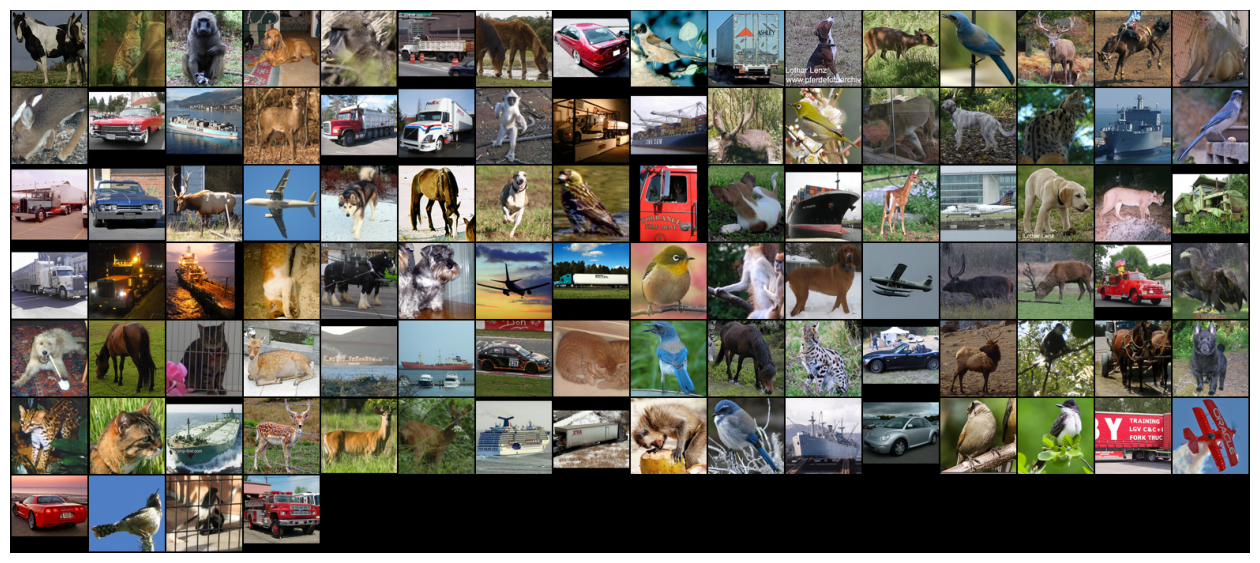

In [14]:
for images, labels in trainLoader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

TEST

In [16]:
import torchvision
model = models.densenet121()# se carga desde torchvision.models, # significa que el modelo utilize sus conocimientos previos
# model = model.to(device)
# #en resumen descargame los pesos que ya tiene este modelo(true) y (freeze)no me los cambies
# for param in model.parameters():
#     param.requires_grad = False#congelamiento de capas
#     #Al congelar ciertas capas de un modelo preentrenado, puedes utilizarlas como extractores de características fijas y
#     #evitar que se ajusten a los datos de entrenamiento. Esto puede ayudar a prevenir el sobreajuste y mejorar la generalización.
# summary(model, (3, 224, 224))


In [17]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

real test

In [18]:
import torchvision
import torch

class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=10, pretrained=True, freeze=False):
        super().__init__()
        # Descargamos DenseNet
        densenet = torchvision.models.densenet121(pretrained=pretrained)

        # Modificamos la primera capa convolucional para que acepte imágenes de 96x96 píxeles
        densenet.features[0] = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)

        # Nos quedamos con todas las capas excepto la última
        self.features = torch.nn.Sequential(*list(densenet.children())[:-1])

        if freeze:
            for param in self.features.parameters():
                param.requires_grad = False

        # Añadimos una nueva capa lineal para la clasificación
        self.fc = torch.nn.Linear(1024, n_outputs)  # En DenseNet121, la dimensión de salida es 1024

    def forward(self, x):
      x = self.features(x)

      # If the spatial size isn't reduced to 1x1, add this:
      x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))

      x = x.view(x.size(0), -1)
      x = self.fc(x)
      return x

    def unfreeze(self):
      for param in self.features.parameters():
        param.requires_grad=True


In [19]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 96, 96))
outputs.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 47.5MB/s]


torch.Size([64, 10])

In [34]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10, lr=0.7e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader2['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader2['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [35]:
from torchvision.models.mobilenetv3 import Weights
#transfer learning a resnet50
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader2)
#con weights: false y freeze : false los reusltados son existe un sobreajsute
#Resultados
#acc 0.90645 val_acc 0.52234 con estos datos (20 epochs , 1e-3 LR, pretrained=true, freeze=false)
#acc 0.99664 val_acc 0.59729 con (10 epochs, 1e-2, pretrained=true, freeze=false)

val_loss 1.72237 val_acc 0.36731: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Epoch 1/10 loss 1.69838 val_loss 1.72237 acc 0.38212 val_acc 0.36731


val_loss 1.41739 val_acc 0.48706: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Epoch 2/10 loss 1.13275 val_loss 1.41739 acc 0.58505 val_acc 0.48706


val_loss 1.38590 val_acc 0.50378: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Epoch 3/10 loss 0.76382 val_loss 1.38590 acc 0.73892 val_acc 0.50378


val_loss 1.37223 val_acc 0.54980: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch 4/10 loss 0.47299 val_loss 1.37223 acc 0.85621 val_acc 0.54980


val_loss 1.81025 val_acc 0.45361: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch 5/10 loss 0.25677 val_loss 1.81025 acc 0.93790 val_acc 0.45361


val_loss 1.54842 val_acc 0.56372: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Epoch 6/10 loss 0.16536 val_loss 1.54842 acc 0.96519 val_acc 0.56372


val_loss 1.76812 val_acc 0.50012: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Epoch 7/10 loss 0.09346 val_loss 1.76812 acc 0.98675 val_acc 0.50012


val_loss 1.56108 val_acc 0.54382: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 8/10 loss 0.10433 val_loss 1.56108 acc 0.97903 val_acc 0.54382


val_loss 1.75351 val_acc 0.50879: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 9/10 loss 0.06493 val_loss 1.75351 acc 0.98714 val_acc 0.50879


val_loss 1.44939 val_acc 0.59729: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]

Epoch 10/10 loss 0.03886 val_loss 1.44939 acc 0.99664 val_acc 0.59729


In [37]:
model = ModelCustom(pretrained=True, freeze=False)
fit(model, dataloader2)
model.unfreeze()
fit(model, dataloader2, lr=1e-3)
#acc 0.96697 val_acc 0.55688 con estos datos. (20 epochs , 1e-3 LR, pretrained=true, freeze=false, afinado con 1e-4)
#acc 0.99782 val_acc 0.66638 con (10 epochs, 1e-2, pretrained=true, freeze=false, freeze=false, afinado con 1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 1.51496 val_acc 0.42700: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 1/10 loss 1.68033 val_loss 1.51496 acc 0.38726 val_acc 0.42700


val_loss 1.56033 val_acc 0.42786: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Epoch 2/10 loss 1.06214 val_loss 1.56033 acc 0.62164 val_acc 0.42786


val_loss 1.35021 val_acc 0.53931: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 3/10 loss 0.74327 val_loss 1.35021 acc 0.74189 val_acc 0.53931


val_loss 1.11730 val_acc 0.61023: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch 4/10 loss 0.44262 val_loss 1.11730 acc 0.86254 val_acc 0.61023


val_loss 1.24152 val_acc 0.60095: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch 5/10 loss 0.23483 val_loss 1.24152 acc 0.94541 val_acc 0.60095


val_loss 1.74411 val_acc 0.50696: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Epoch 6/10 loss 0.12971 val_loss 1.74411 acc 0.97567 val_acc 0.50696


val_loss 2.06100 val_acc 0.43872: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch 7/10 loss 0.10440 val_loss 2.06100 acc 0.98279 val_acc 0.43872


val_loss 1.41334 val_acc 0.59888: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 8/10 loss 0.08473 val_loss 1.41334 acc 0.98734 val_acc 0.59888


val_loss 1.73016 val_acc 0.55432: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 9/10 loss 0.04495 val_loss 1.73016 acc 0.99506 val_acc 0.55432


val_loss 1.31667 val_acc 0.62634: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Epoch 10/10 loss 0.03860 val_loss 1.31667 acc 0.99565 val_acc 0.62634


val_loss 1.25854 val_acc 0.65088: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Epoch 1/10 loss 0.03215 val_loss 1.25854 acc 0.99525 val_acc 0.65088


val_loss 1.23155 val_acc 0.65308: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 2/10 loss 0.02521 val_loss 1.23155 acc 0.99802 val_acc 0.65308


val_loss 1.23498 val_acc 0.65088: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 3/10 loss 0.01968 val_loss 1.23498 acc 0.99901 val_acc 0.65088


val_loss 1.24366 val_acc 0.65027: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Epoch 4/10 loss 0.02390 val_loss 1.24366 acc 0.99644 val_acc 0.65027


val_loss 1.24221 val_acc 0.65393: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 5/10 loss 0.01936 val_loss 1.24221 acc 0.99802 val_acc 0.65393


val_loss 1.24998 val_acc 0.64783: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 6/10 loss 0.03077 val_loss 1.24998 acc 0.99506 val_acc 0.64783


val_loss 1.23842 val_acc 0.65894: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


Epoch 7/10 loss 0.01922 val_loss 1.23842 acc 0.99624 val_acc 0.65894


val_loss 1.22734 val_acc 0.65686: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Epoch 8/10 loss 0.01898 val_loss 1.22734 acc 0.99802 val_acc 0.65686


val_loss 1.23338 val_acc 0.65784: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 9/10 loss 0.01594 val_loss 1.23338 acc 1.00000 val_acc 0.65784


val_loss 1.24905 val_acc 0.65613: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]

Epoch 10/10 loss 0.02191 val_loss 1.24905 acc 0.99684 val_acc 0.65613


In [ ]:
# # newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
# # summary(newmodel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# len(trainLoader)

NameError: ignored

In [ ]:


# X_train=[]
# for i, (images, labels) in enumerate(trainLoader):
#   images = images.to(device)
#   labels = labels.to(device)
#   outputs = newmodel(images)
#   for loop in range(batch_size):
#     out = outputs.data[loop].detach().to("cpu").numpy()
#     temp=out.tolist()
#     temp = list(itertools.chain(*temp))
#     temp = list(itertools.chain(*temp))
#     X_train.append(temp)



In [ ]:
# print("Length of X_train: ",len(X_train))
# df_train = pd.DataFrame(X_train)
# df_train.shape

NameError: ignored

In [ ]:
# X_test=[]
# for i, (images, labels) in enumerate(testLoader):
#   images = images.to(device)
#   labels = labels.to(device)
#   outputs = newmodel(images)
#   for loop in range(batch_size):
#     out = outputs.data[loop].detach().to("cpu").numpy()
#     temp=out.tolist()
#     temp = list(itertools.chain(*temp))
#     temp = list(itertools.chain(*temp))
#     X_test.append(temp)

In [ ]:

# print("Length of X_train",len(X_test))
# df_test = pd.DataFrame(X_test)
# df_test.shape


In [ ]:
# #df_train
# print(df_train.shape)
# Y_train =train_labels
# print("Length of Y_train", len(Y_train))

(5000, 2048)
Length of Y_train 5000


In [ ]:

# #df_test
# print(df_test.shape)
# Y_test =test_labels
# print("Length of Y_test", len(Y_test))

(8000, 2048)
Length of Y_test 8000


In [ ]:


# Xtrain = (df_train - np.min(df_train))/(np.max(df_train)-np.min(df_train)).values
# Xtest = (df_test - np.min(df_test))/(np.max(df_test)-np.min(df_test)).values



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: 

In [ ]:
# model = svm.SVC(kernel='rbf', gamma=0.001,C=200)

In [ ]:
# svm_model = model.fit(Xtrain,Y_train)

In [ ]:
# #Prediction using SVM
# X_train_pred = svm_model.predict(Xtrain)

In [ ]:
# len(X_train_pred)

5000

In [ ]:
# def accuracy(y_true, y_pred):
#     accuracy = np.sum(y_true == y_pred) / len(y_true)
#     return accuracy

In [ ]:
# print("Accuracy: ", accuracy(Y_train, X_train_pred))

Accuracy:  0.8286


Confusion matrix

In [ ]:
# y_actu = pd.Series(Y_train, name='Actual')
# y_pred = pd.Series(X_train_pred, name='Predicted')
# df_confusion = pd.crosstab(y_actu, y_pred, margins=False)
# print(df_confusion.to_numpy())

NameError: ignored

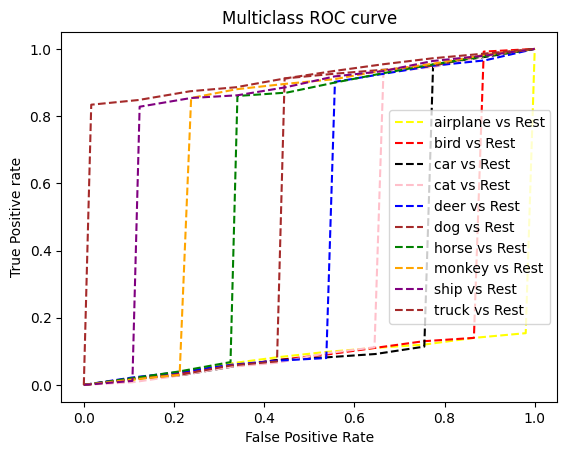

In [ ]:
# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# n_class = len(classes)

# colors=['yellow','red', 'black','pink', 'blue', 'brown', 'green','orange','purple','brown']
# for i in range(n_class):
#     fpr[i], tpr[i], thresh[i] = roc_curve(Y_train, X_train_pred, pos_label=i)
#     plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label= classes[i] +' vs Rest')

# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=600);

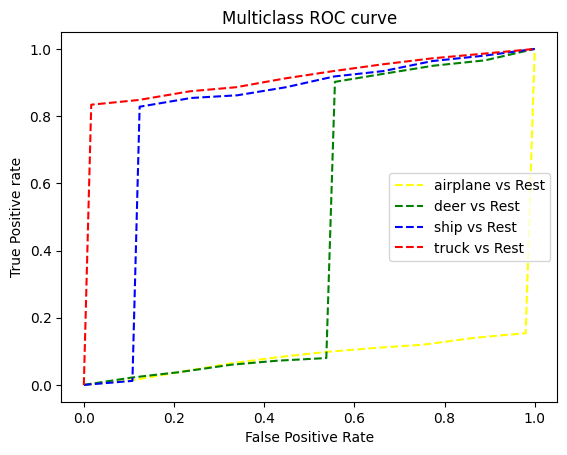

In [ ]:
# # plotting
# plt.plot(fpr[0], tpr[0], linestyle='--',color='yellow', label= classes[0] +' vs Rest')
# plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label=classes[4] +' vs Rest')
# plt.plot(fpr[8], tpr[8], linestyle='--',color='blue', label=classes[8] +' vs Rest')
# plt.plot(fpr[9], tpr[9], linestyle='--',color='red', label=classes[9] +' vs Rest')
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
# Xtest_pred = svm_model.predict(Xtest)

In [ ]:
# print("Accuracy: ", accuracy(Y_test, Xtest_pred))

Accuracy:  0.097875


In [ ]:


# y_actu = pd.Series(Y_test, name='Actual')
# y_pred = pd.Series(Xtest_pred, name='Predicted')
# df_confusion = pd.crosstab(y_actu, y_pred, margins=False)
# print(df_confusion.to_numpy())



NameError: ignored

In [ ]:


# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# n_class = len(classes)

# colors=['yellow','red', 'black','pink', 'blue', 'brown', 'green','orange','purple','brown']
# for i in range(n_class):
#     fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, Xtest_pred, pos_label=i)



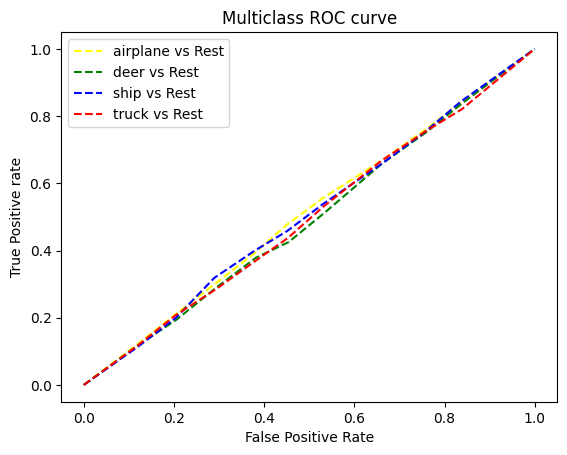

In [ ]:

# # plotting
# plt.plot(fpr[0], tpr[0], linestyle='--',color='yellow', label= classes[0] +' vs Rest')
# plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label=classes[4] +' vs Rest')
# plt.plot(fpr[8], tpr[8], linestyle='--',color='blue', label=classes[8] +' vs Rest')
# plt.plot(fpr[9], tpr[9], linestyle='--',color='red', label=classes[9] +' vs Rest')
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300);